In [195]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

In [196]:
plt.style.use('seaborn-v0_8-dark-palette')

In [241]:
region = 'north_west_pacific_ocean'

In [242]:
track_data_config = {
    'south_pacific_ocean': '/project/cyclone_data/raw_data/south_pacific_ocean_hurricane/south_pacific_hurricane.csv',
    
    'south_indian_ocean': '/project/cyclone_data/raw_data/south_indian_ocean_hurricane/south_indian_hurricane.csv',
    
    'north_indian_ocean': '/project/cyclone_data/raw_data/north_indian_ocean_cyclone/northindianocean.csv',
    
    'north_west_pacific_ocean': '/project/cyclone_data/raw_data/north_west_pacific_ocean_cyclone/north-westpacificocean.csv',
}

In [243]:
def get_tracks_df(region):
    tracks_df = pd.read_csv(track_data_config[region], header=None) 

    tracks_df = tracks_df.rename(columns={0: 'id', 1: 'ts', 2: 'lat', 3: 'lon', 4: 'intensity'})

    return tracks_df

In [244]:
tracks_df = get_tracks_df(region)
tracks_df

,id,ts,lat,lon,intensity
0,1,1969111400,20.1,154.5,20
1,1,1969111406,20.8,153.3,20
2,1,1969111412,21.7,153.2,20
3,1,1969111418,22.8,153.6,20
4,1,1969111500,24.3,154.1,20
...,...,...,...,...,...
14846,491,2013050100,13.9,147.5,60
14847,491,2013050106,13.6,146.6,50
14848,491,2013050112,13.3,145.4,35
14849,491,2013050118,12.5,144.4,25


In [245]:
tracks_df['diff'] = tracks_df['id'].diff().astype(bool)

track_id = 0

def set_track_id(r):
    global track_id
    if r['diff']:
        track_id += 1
    r['track_id'] = track_id
    return r

tracks_df = tracks_df.apply(set_track_id, axis=1)

tracks_df = tracks_df[tracks_df.id != '#VALUE!']
tracks_df = tracks_df[tracks_df.lat != '#VALUE!']
tracks_df = tracks_df[tracks_df.lon != '#VALUE!']
tracks_df = tracks_df[tracks_df.intensity != '#VALUE!']

tracks_df.dropna(inplace=True)

tracks_df.lat = tracks_df.lat.astype('float')
tracks_df.lon = tracks_df.lon.astype('float')

In [246]:
track_lengths = tracks_df.groupby('track_id').agg({
    'lat': ['first', 'last'],
    'lon': ['first', 'last']
})

track_lengths['dist'] = np.sqrt(
    np.square(track_lengths['lat']['last'] - track_lengths['lat']['first']) +
    np.square(track_lengths['lon']['last'] - track_lengths['lon']['first'])
)

track_lengths

lat          lon              dist
         first  last  first   last           
track_id                                     
1         20.1  31.3  154.5  154.1  11.207141
2         15.8  20.8  165.0  148.6  17.145262
3          9.0  15.6  174.9  176.0   6.691039
4         12.4  25.9  185.0  184.6  13.505925
5         13.8  24.4  138.7  158.7  22.635371
...        ...   ...    ...    ...        ...
487       16.3  17.6  137.4  144.8   7.513322
488       15.8  23.2  198.7  212.6  15.747063
489       17.6  36.6  151.4  171.9  27.950850
490       11.6  19.2  144.3  150.8  10.000500
491       10.0  11.7  154.5  143.0  11.624973

[491 rows x 5 columns]

In [247]:
def minimax_scale(x):
    x_max = x.max()
    x_min = x.min()
    return (x - x_min)/(x_max - x_min)

In [258]:
track_sample = np.random.choice(track_lengths.sort_values(by='dist', ascending=False).index[:200], 20)

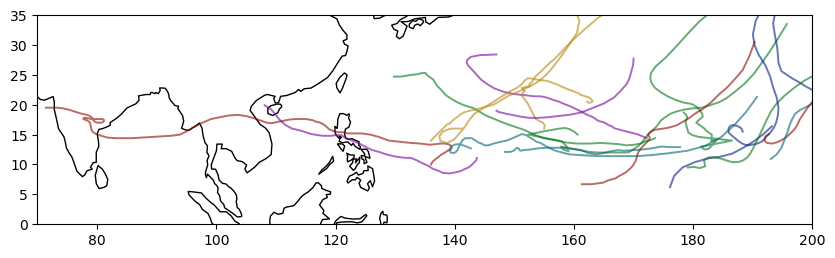

In [259]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[['continent', 'geometry']]
continents = world.dissolve(by='continent').reset_index()
oceania = continents[continents['continent'].isin(["Asia", "Oceania"])]

ax = oceania.plot(figsize=(10, 6), facecolor='none')

# track_sample = np.random.choice(tracks_df.track_id.unique(), 5)

for track_id in track_sample:
    track = tracks_df.loc[tracks_df.track_id==track_id]
    geometry = [Point(xy) for xy in zip(track['lon'], track['lat'])]
    gdf = GeoDataFrame(track, geometry=geometry)
    ax.plot(track['lon'], track['lat'], alpha=0.6, linewidth=1.4)

ax.set_xbound(70, 200)
ax.set_ybound(0, 35)
ax.grid(False)

plt.savefig(f'/project/plots/{region}_tracks.png', bbox_inches='tight')